In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [3]:
# read training data
# report_id - ID to identify report
# report_params - number of parameters to execute report (when more params specified - report will be generated faster)
# day_part - when report is executed (morning, midday or afternoon) - there is less load in the morning and in the afternoon reports are generated slower
# exec_time - time spent to produce report

column_names = ['report_id','report_params','day_part','exec_time']
raw_dataframe = pd.read_csv('report_exec_times.csv')
dataframe = raw_dataframe.copy()

dataframe.head()

,report_id,report_params,day_part,exec_time
0,1,5,2,380
1,1,4,3,450
2,1,8,2,380
3,1,6,1,320
4,1,2,2,391


In [4]:
# report_id and day_part are categorical features. This means we need to encode these two attributes

report_id = dataframe.pop('report_id')
day_part = dataframe.pop('day_part')

In [5]:
# Encoding categorical attributes (creating as many columns as there are unique values and assigning 1 for the column from current row value)

dataframe['report_1'] = (report_id == 1)*1.0
dataframe['report_2'] = (report_id == 2)*1.0
dataframe['report_3'] = (report_id == 3)*1.0
dataframe['report_4'] = (report_id == 4)*1.0
dataframe['report_5'] = (report_id == 5)*1.0

dataframe['day_morning'] = (day_part == 1)*1.0
dataframe['day_midday'] = (day_part == 2)*1.0
dataframe['day_afternoon'] = (day_part == 3)*1.0

dataframe.head()

,report_params,exec_time,report_1,report_2,report_3,report_4,report_5,day_morning,day_midday,day_afternoon
0,5,380,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4,450,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8,380,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6,320,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,391,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
# Splitting training dataset into train (80%) and test data

train_dataset = dataframe.sample(frac=0.8,random_state=0)
test_dataset = dataframe.drop(train_dataset.index)

train_dataset.shape

(1200, 10)

In [7]:
test_dataset.shape

(300, 10)

In [8]:
# Describe train dataset, without target feature - exec_time. Mean and std will be used to normalize training data

train_stats = train_dataset.describe()
train_stats.pop("exec_time")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
report_params,1200.0,4.914167,3.159924,0.0,2.0,5.0,8.0,10.0
report_1,1200.0,0.191667,0.393776,0.0,0.0,0.0,0.0,1.0
report_2,1200.0,0.210000,0.407478,0.0,0.0,0.0,0.0,1.0
report_3,1200.0,0.192500,0.394428,0.0,0.0,0.0,0.0,1.0
report_4,1200.0,0.201667,0.401412,0.0,0.0,0.0,0.0,1.0
report_5,1200.0,0.204167,0.403259,0.0,0.0,0.0,0.0,1.0
day_morning,1200.0,0.360000,0.480200,0.0,0.0,0.0,1.0,1.0
day_midday,1200.0,0.320833,0.466991,0.0,0.0,0.0,1.0,1.0
day_afternoon,1200.0,0.319167,0.466348,0.0,0.0,0.0,1.0,1.0


In [9]:
# Remove exec_time feature from training data and keep it as a target for both training and testing

train_labels = train_dataset.pop('exec_time')
test_labels = test_dataset.pop('exec_time')

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [10]:
# Neural network learns better, when data is normalized (features look similar to each other)

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

normed_train_data = np.array(normed_train_data)
normed_test_data = np.array(normed_test_data)

In [11]:
# Construct neural network with Keras API on top of TensorFlow. SGD optimizer and 
# mean squared error loss to check training quality

def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [14]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, batch_size=40, verbose=1, callbacks=[early_stop])

Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 1s 1ms/sample - loss: 272689.8522 - mae: 472.8838 - mse: 272689.8750 - val_loss: 303697.4609 - val_mae: 499.4886 - val_mse: 303697.4375
Epoch 2/1000
960/960 [==============================] - 0s 89us/sample - loss: 272117.5065 - mae: 472.3325 - mse: 272117.5000 - val_loss: 303100.9740 - val_mae: 498.9537 - val_mse: 303101.0000
Epoch 3/1000
960/960 [==============================] - 0s 73us/sample - loss: 271553.0514 - mae: 471.7896 - mse: 271553.0625 - val_loss: 302456.4896 - val_mae: 498.3681 - val_mse: 302456.5000
Epoch 4/1000
960/960 [==============================] - 0s 77us/sample - loss: 270917.6823 - mae: 471.1740 - mse: 270917.6875 - val_loss: 301711.9688 - val_mae: 497.6920 - val_mse: 301711.9688
Epoch 5/1000
960/960 [==============================] - 0s 71us/sample - loss: 270159.0156 - mae: 470.4457 - mse: 270159.0000 - val_loss: 300809.8307 - val_mae: 496.8806 - val_mse: 30

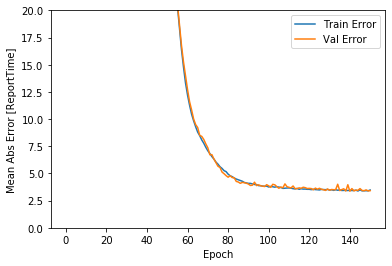

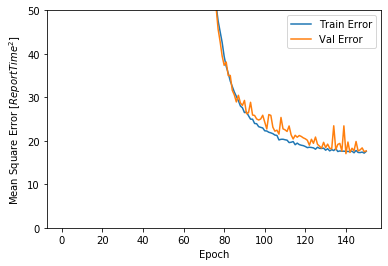

In [15]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ReportTime]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ReportTime^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


plot_history(history)

In [16]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Report Execution Time".format(mae))

Testing set Mean Abs Error:  3.48 Report Execution Time


In [17]:
# Construct test data row with "unseen" feature values - report_params = 15 

headers = ['report_id', 'report_params', 'day_part']
dataset_input = pd.DataFrame([[1, 15, 3]],
                                columns=headers, 
                                dtype=float,
                                index=['input'])

print(dataset_input)

       report_id  report_params  day_part
input        1.0           15.0       3.0


In [18]:
# Encode categorical features for test data row

report_id = dataset_input.pop('report_id')
day_part = dataset_input.pop('day_part')

dataset_input['report_1'] = (report_id == 1)*1.0
dataset_input['report_2'] = (report_id == 2)*1.0
dataset_input['report_3'] = (report_id == 3)*1.0
dataset_input['report_4'] = (report_id == 4)*1.0
dataset_input['report_5'] = (report_id == 5)*1.0

dataset_input['day_morning'] = (day_part == 1)*1.0
dataset_input['day_midday'] = (day_part == 2)*1.0
dataset_input['day_afternoon'] = (day_part == 3)*1.0

dataset_input.tail()

,report_params,report_1,report_2,report_3,report_4,report_5,day_morning,day_midday,day_afternoon
input,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# Normalize test data row

normed_dataset_input = norm(dataset_input)
normed_dataset_input = np.array(normed_dataset_input)

print(normed_dataset_input)

[[ 3.19179609  2.05277296 -0.51536518 -0.4880486  -0.50239337 -0.50629114
  -0.74968743 -0.68702182  1.45992522]]


In [20]:
# Prediction result for report execution time. This is correct, model learns the rule correct - more report params, means execution time will be less

res = model.predict(normed_dataset_input)
print(res)

[[424.9289]]


In [26]:
import calendar;
import time;
ts = calendar.timegm(time.gmtime())

tf.saved_model.save(model, "./model_report_exec_time/" + str(ts))